In [1]:
import h5py
import numpy as np
import os,random
from keras.layers import Input,Reshape,ZeroPadding2D,Conv2D,Dropout,Flatten,Dense,Activation,MaxPooling2D,AlphaDropout
from keras import layers
import keras.models as Model
from keras.regularizers import *
from keras.optimizers import adam
import seaborn as sns
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import gc
%matplotlib inline
os.environ["KERAS_BACKEND"] = "tensorflow"

In [2]:
for i in range(0,24): #24个数据集文件
    ########open file#######
    filename = 'F:\sourceCode\AMC-2\ExtractDataset\part'+str(i) + '.h5'
    print(filename)
    f = h5py.File(filename,'r')
    ########读取数据#######
    X_data = f['X'][:]
    Y_data = f['Y'][:]
    Z_data = f['Z'][:]
    f.close()
    #########分割训练集和测试集#########
    #每读取到一个数据文件就直接分割为训练集和测试集，防止爆内存
    n_examples = X_data.shape[0]
    n_train = int(n_examples * 0.7)   #70%训练样本
    train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)#随机选取训练样本下标
    test_idx = list(set(range(0,n_examples))-set(train_idx))        #测试样本下标
    if i == 0:
        X_train = X_data[train_idx]
        Y_train = Y_data[train_idx]
        Z_train = Z_data[train_idx]
        X_test = X_data[test_idx]
        Y_test = Y_data[test_idx]
        Z_test = Z_data[test_idx]
    else:
        #垂直堆叠
        X_train = np.vstack((X_train, X_data[train_idx]))
        Y_train = np.vstack((Y_train, Y_data[train_idx]))
        Z_train = np.vstack((Z_train, Z_data[train_idx]))
        X_test = np.vstack((X_test, X_data[test_idx]))
        Y_test = np.vstack((Y_test, Y_data[test_idx]))
        Z_test = np.vstack((Z_test, Z_data[test_idx]))
print('训练集X维度：',X_train.shape)
print('训练集Y维度：',Y_train.shape)
print('训练集Z维度：',Z_train.shape)
print('测试集X维度：',X_test.shape)
print('测试集Y维度：',Y_test.shape)
print('测试集Z维度：',Z_test.shape)

F:\sourceCode\AMC-2\ExtractDataset\part0.h5
F:\sourceCode\AMC-2\ExtractDataset\part1.h5
F:\sourceCode\AMC-2\ExtractDataset\part2.h5
F:\sourceCode\AMC-2\ExtractDataset\part3.h5
F:\sourceCode\AMC-2\ExtractDataset\part4.h5
F:\sourceCode\AMC-2\ExtractDataset\part5.h5
F:\sourceCode\AMC-2\ExtractDataset\part6.h5
F:\sourceCode\AMC-2\ExtractDataset\part7.h5
F:\sourceCode\AMC-2\ExtractDataset\part8.h5
F:\sourceCode\AMC-2\ExtractDataset\part9.h5
F:\sourceCode\AMC-2\ExtractDataset\part10.h5
F:\sourceCode\AMC-2\ExtractDataset\part11.h5
F:\sourceCode\AMC-2\ExtractDataset\part12.h5
F:\sourceCode\AMC-2\ExtractDataset\part13.h5
F:\sourceCode\AMC-2\ExtractDataset\part14.h5
F:\sourceCode\AMC-2\ExtractDataset\part15.h5
F:\sourceCode\AMC-2\ExtractDataset\part16.h5
F:\sourceCode\AMC-2\ExtractDataset\part17.h5
F:\sourceCode\AMC-2\ExtractDataset\part18.h5
F:\sourceCode\AMC-2\ExtractDataset\part19.h5
F:\sourceCode\AMC-2\ExtractDataset\part20.h5
F:\sourceCode\AMC-2\ExtractDataset\part21.h5
F:\sourceCode\AMC-2\

snr: [20]
Y [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


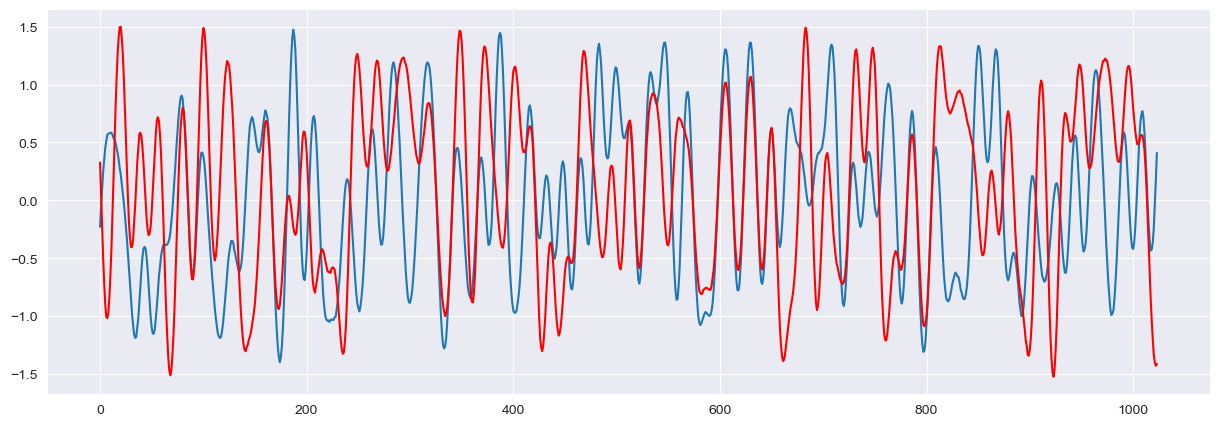

In [3]:
##查看数据是否正常
sample_idx = 520329 #随机下标
print('snr:',Z_train[sample_idx])
print('Y',Y_train[sample_idx])
plt_data = X_train[sample_idx].T
plt.figure(figsize=(15,5))
plt.plot(plt_data[0])
plt.plot(plt_data[1],color = 'red')
plt.show()

In [4]:
"""建立模型"""
classes = ['32PSK',
 '16APSK',
 '32QAM',
 'FM',
 'GMSK',
 '32APSK',
 'OQPSK',
 '8ASK',
 'BPSK',
 '8PSK',
 'AM-SSB-SC',
 '4ASK',
 '16PSK',
 '64APSK',
 '128QAM',
 '128APSK',
 'AM-DSB-SC',
 'AM-SSB-WC',
 '64QAM',
 'QPSK',
 '256QAM',
 'AM-DSB-WC',
 'OOK',
 '16QAM']
data_format = 'channels_first'

def residual_stack(Xm,kennel_size,Seq,pool_size):
    #1*1 Conv Linear
    Xm = Conv2D(32, (1, 1), padding='same', name=Seq+"_conv1", kernel_initializer='glorot_normal',data_format=data_format)(Xm)
    #Residual Unit 1
    Xm_shortcut = Xm
    Xm = Conv2D(32, kennel_size, padding='same',activation="relu",name=Seq+"_conv2", kernel_initializer='glorot_normal',data_format=data_format)(Xm)
    Xm = Conv2D(32, kennel_size, padding='same', name=Seq+"_conv3", kernel_initializer='glorot_normal',data_format=data_format)(Xm)
    Xm = layers.add([Xm,Xm_shortcut])
    Xm = Activation("relu")(Xm)
    #Residual Unit 2
    Xm_shortcut = Xm
    Xm = Conv2D(32, kennel_size, padding='same',activation="relu",name=Seq+"_conv4", kernel_initializer='glorot_normal',data_format=data_format)(Xm)
    X = Conv2D(32, kennel_size, padding='same', name=Seq+"_conv5", kernel_initializer='glorot_normal',data_format=data_format)(Xm)
    Xm = layers.add([Xm,Xm_shortcut])
    Xm = Activation("relu")(Xm)
    #MaxPooling
    Xm = MaxPooling2D(pool_size=pool_size, strides=pool_size, padding='valid', data_format=data_format)(Xm)
    return Xm




In [5]:
in_shp = X_train.shape[1:]   #每个样本的维度[1024,2]
#input layer
Xm_input = Input(in_shp)
Xm = Reshape([1,1024,2], input_shape=in_shp)(Xm_input)

In [ ]:
#Residual Stack
Xm = residual_stack(Xm,kennel_size=(3,2),Seq="ReStk0",pool_size=(2,2))   #shape:(512,1,32)


In [ ]:
Xm = residual_stack(Xm,kennel_size=(3,1),Seq="ReStk1",pool_size=(2,1))   #shape:(256,1,32)


In [ ]:
Xm = residual_stack(Xm,kennel_size=(3,1),Seq="ReStk2",pool_size=(2,1))   #shape:(128,1,32)


In [ ]:
Xm = residual_stack(Xm,kennel_size=(3,1),Seq="ReStk3",pool_size=(2,1))   #shape:(64,1,32)


In [ ]:
Xm = residual_stack(Xm,kennel_size=(3,1),Seq="ReStk4",pool_size=(2,1))   #shape:(32,1,32)


In [ ]:
Xm = residual_stack(Xm,kennel_size=(3,1),Seq="ReStk5",pool_size=(2,1))   #shape:(16,1,32)

In [ ]:
#############################################################################
#      多次尝试发现减少一层全连接层能使loss下降更快
#      将AlphaDropout设置为0.3似乎比0.5效果更好
#############################################################################
#Full Con 1
Xm = Flatten(data_format=data_format)(Xm)
Xm = Dense(128, activation='selu', kernel_initializer='glorot_normal', name="dense1")(Xm)
Xm = AlphaDropout(0.3)(Xm)
#Full Con 2
Xm = Dense(len(classes), kernel_initializer='glorot_normal', name="dense2")(Xm)
#SoftMax
Xm = Activation('softmax')(Xm)

In [ ]:
#Create Model
model = Model.Model(inputs=Xm_input,outputs=Xm)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam)
model.summary()

In [ ]:
"""训练模型"""
#############################################################################
#      当val_loss连续10次迭代不再减小或总迭代次数大于100时停止
#      将最小验证损失的模型保存
#############################################################################
print(tf.test.gpu_device_name())
filepath = 'F:\sourceCode\AMC-2\ResNet_Model_72w.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=1000,
    epochs=100,
    verbose=2,
    validation_data=(X_test, Y_test),
    #validation_split = 0.3,
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)


In [ ]:
val_loss_list = history.history['val_loss']
loss_list = history.history['loss']
plt.plot(range(len(loss_list)),val_loss_list)
plt.plot(range(len(loss_list)),loss_list,color = "red")
plt.show()

In [ ]:
##########从loss走势来看，预计loss还能继续下降，故再训练一次#######
history = model.fit(X_train,
    Y_train,
    batch_size=1000,
    epochs=100,
    verbose=2,
    validation_data=(X_test, Y_test),
    #validation_split = 0.3,
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Plot confusion matrix
batch_size = 1024
test_Y_hat = model.predict(X_test, batch_size=1024)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

In [ ]:
for i in range(len(confnorm)):
    print(classes[i],confnorm[i,i])

In [ ]:
acc={}
Z_test = Z_test.reshape((len(Z_test)))
SNRs = np.unique(Z_test)
for snr in SNRs:
    X_test_snr = X_test[Z_test==snr]
    Y_test_snr = Y_test[Z_test==snr]

    pre_Y_test = model.predict(X_test_snr)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,X_test_snr.shape[0]):    #该信噪比下测试数据量
        j = list(Y_test_snr[i,:]).index(1)   #正确类别下标
        j = classes.index(classes[j])
        k = int(np.argmax(pre_Y_test[i,:])) #预测类别下标
        k = classes.index(classes[k])
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy %s: "%snr, cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

In [ ]:
plt.plot(acc.keys(),acc.values())
plt.ylabel('ACC')
plt.xlabel('SNR')
plt.show()